In [116]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model

import os
from collections import deque
import numpy as np
import argparse
import cv2

import matplotlib.pyplot as plt

In [135]:
imagefile = 'path/to/image.jpg'
output_location = 'path/to/output/folder/'
model_location = 'path/to/model.h5'

In [126]:
def get_model():
    # load the VGG16 network, ensuring the head FC layer sets are left
    # off
    baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

    # construct the head of the model that will be placed on top of the
    # the base model
    headModel = baseModel.output
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(512, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(1, activation="sigmoid")(headModel)

    # place the head FC model on top of the base model (this will become
    # the actual model we will train)
    model = Model(inputs=baseModel.input, outputs=headModel)

    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable = False

    # compile our model (this needs to be done after our setting our
    # layers to being non-trainable
    print("[INFO] compiling model...")
    opt = SGD(lr=1e-6, momentum=0.9)
    model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
    return model

In [127]:
model = get_model()
model.load_weights(model_location)

[INFO] compiling model...


In [136]:
print("[INFO] Generating Prediction...")

frame = cv2.imread(imagefile)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
output = frame.copy()
frame = cv2.resize(frame, (224, 224))
frame = frame.astype("float32")
prediction = model.predict(np.expand_dims(frame, axis=0))[0][0]

[INFO] Generating Prediction...


[INFO] Generating Image...


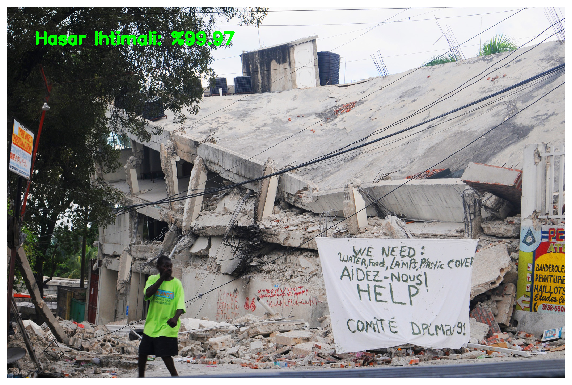

In [140]:
print("[INFO] Generating Image...")

text = "Hasar Ihtimali: %{:.2f}".format(prediction*100)
x_coord = output.shape[1]//20
y_coord = output.shape[0]//10
font_scale = output.shape[1]/1000
font_thickness = output.shape[1]//200
cv2.putText(output, text, (x_coord, y_coord), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), font_thickness)
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(output)
plt.show()

oLocation = output_location + "//" + imagefile[-(imagefile[::-1].find('/')):-(imagefile[::-1].find('.'))-1]+"_deprem.png"
plt.imsave(oLocation, output)